In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: segniab
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset


100%|██████████| 2.04G/2.04G [00:16<00:00, 135MB/s] 


In [ ]:
#  Environment and GPU check ======
import torch, torchvision, os, random, sys
import numpy as np

print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

PyTorch: 2.8.0+cu126
Torchvision: 0.23.0+cu126
CUDA available: True
Using device: cuda


In [ ]:
# Set dataset root (exact path) and validate ======
import os, glob

DATA_ROOT = "/content/plantvillage-dataset/plantvillage dataset/color"
TARGET_CLASSES = ["Potato___healthy", "Potato___Early_blight", "Potato___Late_blight"]

assert os.path.isdir(DATA_ROOT), f"DATA_ROOT not found: {DATA_ROOT}"
for cls in TARGET_CLASSES:
    cls_path = os.path.join(DATA_ROOT, cls)
    assert os.path.isdir(cls_path), f"Missing class folder: {cls_path}"

# Count images per class
counts = {}
for cls in TARGET_CLASSES:
    imgs = [p for p in glob.glob(os.path.join(DATA_ROOT, cls, "*")) if p.lower().endswith((".jpg",".jpeg",".png"))]
    counts[cls] = len(imgs)
print("Class counts:", counts)

Class counts: {'Potato___healthy': 152, 'Potato___Early_blight': 1000, 'Potato___Late_blight': 1000}


In [ ]:
#  Train/validation split ======
from sklearn.model_selection import train_test_split
import shutil

SPLIT_ROOT = "/content/potato_split_color"
TRAIN_DIR = os.path.join(SPLIT_ROOT, "train")
VAL_DIR = os.path.join(SPLIT_ROOT, "val")
for d in [TRAIN_DIR, VAL_DIR]:
    os.makedirs(d, exist_ok=True)

VAL_RATIO = 0.2

for cls in TARGET_CLASSES:
    src = os.path.join(DATA_ROOT, cls)
    paths = [p for p in glob.glob(os.path.join(src, "*")) if p.lower().endswith((".jpg",".jpeg",".png"))]
    train_paths, val_paths = train_test_split(paths, test_size=VAL_RATIO, random_state=SEED, shuffle=True)
    os.makedirs(os.path.join(TRAIN_DIR, cls), exist_ok=True)
    os.makedirs(os.path.join(VAL_DIR, cls), exist_ok=True)
    for p in train_paths:
        shutil.copy(p, os.path.join(TRAIN_DIR, cls, os.path.basename(p)))
    for p in val_paths:
        shutil.copy(p, os.path.join(VAL_DIR, cls, os.path.basename(p)))

# Print split counts
for d in [TRAIN_DIR, VAL_DIR]:
    for cls in TARGET_CLASSES:
        cnt = len([p for p in glob.glob(os.path.join(d, cls, "*")) if p.lower().endswith((".jpg",".jpeg",".png"))])
        print(d, cls, cnt)

/content/potato_split_color/train Potato___healthy 121
/content/potato_split_color/train Potato___Early_blight 800
/content/potato_split_color/train Potato___Late_blight 800
/content/potato_split_color/val Potato___healthy 31
/content/potato_split_color/val Potato___Early_blight 200
/content/potato_split_color/val Potato___Late_blight 200


In [ ]:
#  Datasets and loaders (torchvision transforms) ======
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader

IMG_SIZE = 160
BATCH_SIZE = 64

# Train-time augmentation for robustness
train_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Validation transforms (no augmentation)
val_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
val_ds = datasets.ImageFolder(VAL_DIR, transform=val_tfms)

class_names = train_ds.classes
print("Classes:", class_names)

# If workers cause issues in Colab, set num_workers=0
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [ ]:
# Model (ResNet-18 transfer learning) ======
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

num_classes = len(class_names)

# For newer torchvision: weights=... ; for older: pretrained=True
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze backbone initially
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head
in_feats = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_feats, num_classes)
)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


In [ ]:
#Training loop with early stopping and checkpoint ======
from copy import deepcopy
import time, torch

EPOCHS = 10
patience = 3
best_val_acc = 0.0
best_state = None
no_improve = 0

def run_epoch(loader, train_mode=True):
    if train_mode:
        model.train()
    else:
        model.eval()
    total_loss, total_correct, total_n = 0.0, 0, 0
    with torch.set_grad_enabled(train_mode):
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            if train_mode:
                optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            if train_mode:
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * images.size(0)
            total_correct += (torch.argmax(logits, dim=1) == labels).sum().item()
            total_n += images.size(0)
    return total_loss / total_n, total_correct / total_n

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    train_loss, train_acc = run_epoch(train_loader, train_mode=True)
    val_loss, val_acc = run_epoch(val_loader, train_mode=False)
    dt = time.time() - t0
    print(f"Epoch {epoch:02d} | {dt:.1f}s | Train Loss {train_loss:.4f} Acc {train_acc:.3f} | Val Loss {val_loss:.4f} Acc {val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = deepcopy(model.state_dict())
        no_improve = 0
        torch.save(best_state, "/content/best_head.pt")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping.")
            break

print("Best val acc (head training):", best_val_acc)

Epoch 01 | 9.8s | Train Loss 0.6282 Acc 0.716 | Val Loss 0.4024 Acc 0.884
Epoch 02 | 9.3s | Train Loss 0.3054 Acc 0.916 | Val Loss 0.2958 Acc 0.900
Epoch 03 | 9.1s | Train Loss 0.2240 Acc 0.937 | Val Loss 0.2455 Acc 0.919
Epoch 04 | 8.6s | Train Loss 0.1852 Acc 0.949 | Val Loss 0.2041 Acc 0.940
Epoch 05 | 9.9s | Train Loss 0.1495 Acc 0.961 | Val Loss 0.1803 Acc 0.947
Epoch 06 | 9.3s | Train Loss 0.1597 Acc 0.944 | Val Loss 0.2105 Acc 0.933
Epoch 07 | 8.9s | Train Loss 0.1440 Acc 0.954 | Val Loss 0.1682 Acc 0.951
Epoch 08 | 8.3s | Train Loss 0.1165 Acc 0.967 | Val Loss 0.1425 Acc 0.958
Epoch 09 | 9.2s | Train Loss 0.1095 Acc 0.970 | Val Loss 0.1332 Acc 0.951
Epoch 10 | 9.1s | Train Loss 0.1176 Acc 0.964 | Val Loss 0.1250 Acc 0.956
Best val acc (head training): 0.9582366589327146


In [ ]:
#fine-tuning (unfreeze last block for better accuracy) ======
import torch.optim as optim
model.load_state_dict(torch.load("/content/best_head.pt", map_location=DEVICE))

for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

EPOCHS_FT = 5
best_val_acc_ft = best_val_acc
no_improve = 0

for epoch in range(1, EPOCHS_FT+1):
    train_loss, train_acc = run_epoch(train_loader, train_mode=True)
    val_loss, val_acc = run_epoch(val_loader, train_mode=False)
    print(f"[FT] Epoch {epoch:02d} | Train Loss {train_loss:.4f} Acc {train_acc:.3f} | Val Loss {val_loss:.4f} Acc {val_acc:.3f}")

    if val_acc > best_val_acc_ft:
        best_val_acc_ft = val_acc
        torch.save(model.state_dict(), "/content/best_finetuned.pt")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= 3:
            print("Fine-tuning early stop.")
            break

print("Best val acc after FT:", best_val_acc_ft)

[FT] Epoch 01 | Train Loss 0.0801 Acc 0.972 | Val Loss 0.0411 Acc 0.984
[FT] Epoch 02 | Train Loss 0.0258 Acc 0.991 | Val Loss 0.0420 Acc 0.984
[FT] Epoch 03 | Train Loss 0.0106 Acc 0.997 | Val Loss 0.0230 Acc 0.991
[FT] Epoch 04 | Train Loss 0.0119 Acc 0.997 | Val Loss 0.0197 Acc 0.993
[FT] Epoch 05 | Train Loss 0.0075 Acc 0.999 | Val Loss 0.0175 Acc 0.995
Best val acc after FT: 0.9953596287703016


In [ ]:
 Evaluation (classification report & confusion matrix) ======
from sklearn.metrics import classification_report, confusion_matrix
import os

# Use the best checkpoint (finetuned if available)
CKPT = "/content/best_finetuned.pt" if os.path.exists("/content/best_finetuned.pt") else "/content/best_head.pt"
model.load_state_dict(torch.load(CKPT, map_location=DEVICE))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        logits = model(images)
        preds = torch.argmax(logits, dim=1).cpu().numpy().tolist()
        y_pred.extend(preds)
        y_true.extend(labels.numpy().tolist())

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("Confusion matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

Classification report:
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      1.00      1.00       200
 Potato___Late_blight       0.99      1.00      1.00       200
     Potato___healthy       1.00      0.94      0.97        31

             accuracy                           1.00       431
            macro avg       1.00      0.98      0.99       431
         weighted avg       1.00      1.00      1.00       431

Confusion matrix:
[[200   0   0]
 [  0 200   0]
 [  0   2  29]]


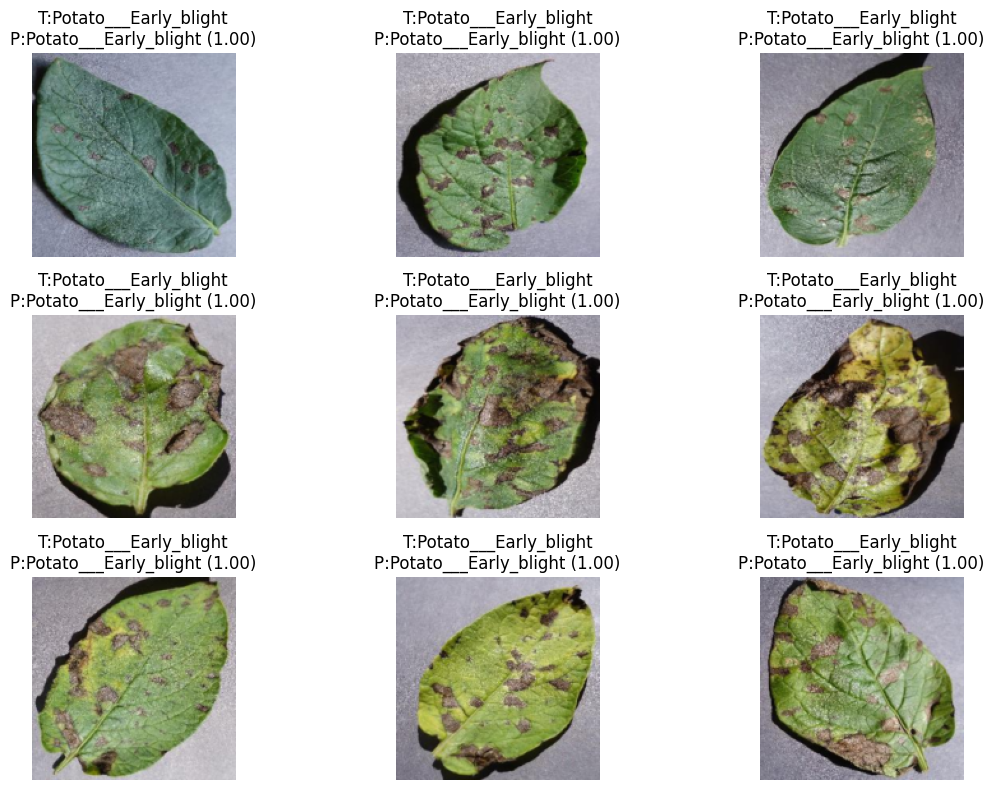

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import torch

def denorm(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return torch.clamp(img_tensor.cpu()*std + mean, 0, 1)

model.eval()
images, labels = next(iter(val_loader))
with torch.no_grad():
    logits = model(images.to(DEVICE))
    probs = torch.softmax(logits, dim=1).cpu().numpy()
    preds = np.argmax(probs, axis=1)

plt.figure(figsize=(12,8))
for i in range(min(9, images.size(0))):
    ax = plt.subplot(3,3,i+1)
    img = denorm(images[i])
    plt.imshow(np.transpose(img.numpy(), (1,2,0)))
    t_label = class_names[labels[i].item()]
    p_label = class_names[preds[i]]
    conf = probs[i][preds[i]]
    plt.title(f"T:{t_label}\nP:{p_label} ({conf:.2f})")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:

EXPORT_DIR = "/content/exported_model_pytorch"
os.makedirs(EXPORT_DIR, exist_ok=True)

import json, torch, os
# Save weights
torch.save(model.state_dict(), os.path.join(EXPORT_DIR, "model.pt"))
# Save class names (order matters)
with open(os.path.join(EXPORT_DIR, "labels.json"), "w") as f:
    json.dump(class_names, f)
# Save model info to ensure consistent preprocessing
with open(os.path.join(EXPORT_DIR, "model_info.txt"), "w") as f:
    f.write("arch=resnet18\nimg_size=160\nnormalize=imagenet\nsubset=color\n")

# Zip it for download
!cd /content && zip -rq exported_model_pytorch.zip exported_model_pytorch
print("Exported at /content/exported_model_pytorch.zip")

Exported at /content/exported_model_pytorch.zip
